In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix

import string
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical


import warnings
warnings.filterwarnings('ignore')

import pickle

In [17]:
from IPython.display import display

In [66]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import nltk

In [33]:
from pathlib import Path

DATA_PATH = Path("../data/raw/Reviews.csv")
print("File exists:", DATA_PATH.exists())


File exists: True


In [34]:
import pandas as pd

df = pd.read_csv(DATA_PATH)

In [35]:
display(df.head(2))

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [16]:
df.shape

(568454, 10)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


# Data Cleaning

In [36]:
df.isnull().sum().to_frame(name="# Empty or null values")

,# Empty or null values
Id,0
ProductId,0
UserId,0
ProfileName,26
HelpfulnessNumerator,0
HelpfulnessDenominator,0
Score,0
Time,0
Summary,27
Text,0


In [37]:
(df.isnull().mean() * 100).sort_values(ascending=False)

Summary                   0.004750
ProfileName               0.004574
ProductId                 0.000000
Id                        0.000000
HelpfulnessNumerator      0.000000
UserId                    0.000000
HelpfulnessDenominator    0.000000
Score                     0.000000
Time                      0.000000
Text                      0.000000
dtype: float64

In [38]:
rows_before = df.shape[0]

df = df.dropna(subset=["Text"])

rows_after = df.shape[0]
removed = rows_before - rows_after

print("Rows removed (missing Text):", removed)
print(f"Remaining: {rows_after} ({round((rows_after/total_rows)*100, 2)}%)")


Rows removed (missing Text): 0
Remaining: 568454 (100.0%)


In [39]:
rows_before = df.shape[0]

df = df.dropna(subset=["Score"])

rows_after = df.shape[0]
removed = rows_before - rows_after

print("Rows removed (missing Score):", removed)
print(f"Remaining: {rows_after} ({round((rows_after/total_rows)*100, 2)}%)")


Rows removed (missing Score): 0
Remaining: 568454 (100.0%)


In [40]:
df.duplicated(subset=["Score", "Text"]).sum()

np.int64(174779)

In [41]:
rows_before = df.shape[0]

df = df.drop_duplicates(subset=["Score", "Text"])

rows_after = df.shape[0]
removed = rows_before - rows_after

print("Duplicate rows removed:", removed)
print(f"Remaining: {rows_after} ({round((rows_after/total_rows)*100, 2)}%)")


Duplicate rows removed: 174779
Remaining: 393675 (69.25%)


In [42]:
df.shape

(393675, 10)

In [48]:
score_dist = df["Score"].value_counts(normalize=True).sort_index() * 100
score_dist.round(2)


Score
1     9.22
2     5.28
3     7.56
4    14.24
5    63.69
Name: proportion, dtype: float64

In [49]:
df["review_length"].describe()


count    393675.000000
mean        433.899610
std         433.084754
min          12.000000
25%         181.000000
50%         304.000000
75%         527.000000
max       21409.000000
Name: review_length, dtype: float64

In [50]:
df.groupby("Score")["review_length"].agg(
    mean_length="mean",
    median_length="median"
).round(0)


,mean_length,median_length
Score,,
1,452.0,332.0
2,493.0,361.0
3,524.0,376.0
4,500.0,350.0
5,401.0,280.0


In [51]:
q95 = df["review_length"].quantile(0.95)
outlier_pct = (df["review_length"] > q95).mean() * 100

q95, round(outlier_pct, 2)


(np.float64(1185.0), np.float64(4.99))

In [52]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words="english", max_features=10000)
vectorizer.fit(df["Text"])

len(vectorizer.get_feature_names_out())


10000

### Score Distribution

# EDA

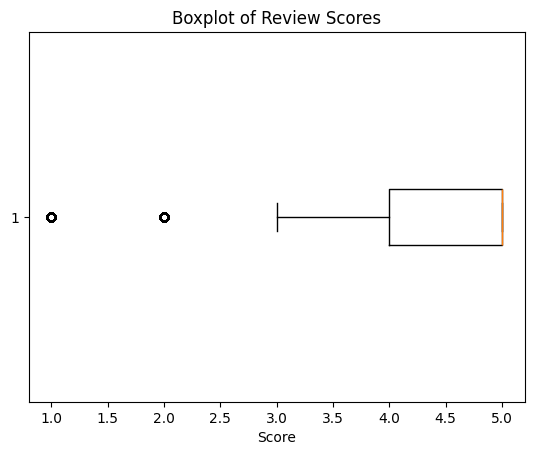

In [43]:
plt.figure()
plt.boxplot(df["Score"], vert=False)
plt.title("Boxplot of Review Scores")
plt.xlabel("Score")
plt.show()


### Lenght analysis

In [44]:
df["review_length"] = df["Text"].astype(str).apply(len)

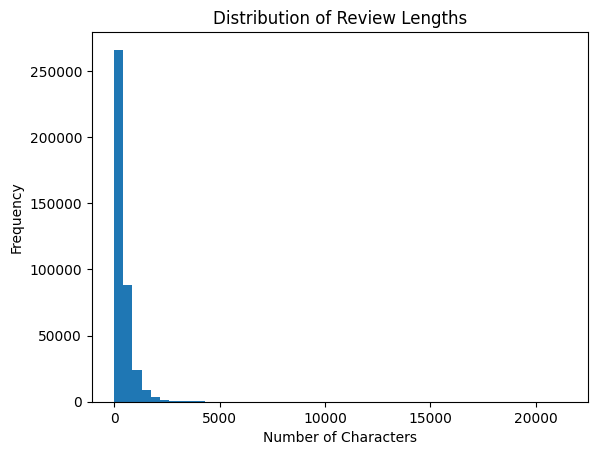

In [45]:
plt.figure()
plt.hist(df["review_length"], bins=50)
plt.title("Distribution of Review Lengths")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.show()


<Figure size 640x480 with 0 Axes>

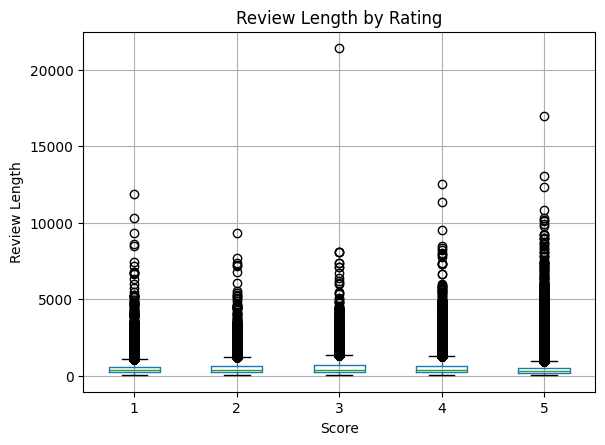

In [46]:
plt.figure()
df.boxplot(column="review_length", by="Score")
plt.suptitle("")
plt.title("Review Length by Rating")
plt.xlabel("Score")
plt.ylabel("Review Length")
plt.show()


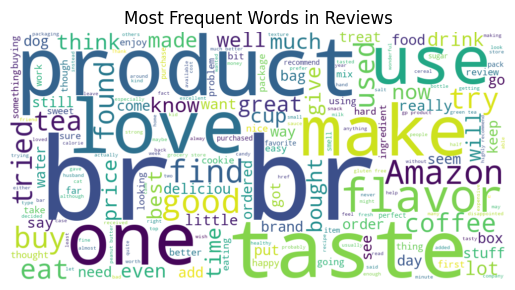

In [47]:
from wordcloud import WordCloud, STOPWORDS

text_blob = " ".join(df["Text"].astype(str))

wordcloud = WordCloud(
    width=1000,
    height=500,
    stopwords=STOPWORDS,
    background_color="white"
).generate(text_blob)

plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words in Reviews")
plt.show()


# Label Freeze

In [55]:
def map_sentiment(score):
    if score <= 2:
        return "Negative"
    elif score ==3:
        return "Neutral"
    else:
        return "Positive"
        
df['sentiment']=df['Score'].apply(map_sentiment) 

In [58]:
sentiment_dist=df['sentiment'].value_counts(normalize=True)*100

In [59]:
sentiment_dist

sentiment
Positive    77.937131
Negative    14.500286
Neutral      7.562583
Name: proportion, dtype: float64

In [61]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['sentiment_encoded']=le.fit_transform(df['sentiment'])
le.classes_

array(['Negative', 'Neutral', 'Positive'], dtype=object)

In [64]:
df[["Score", "sentiment", "sentiment_encoded"]].sample(10)

,Score,sentiment,sentiment_encoded
44548,5,Positive,2
99466,5,Positive,2
55239,5,Positive,2
51043,5,Positive,2
461092,5,Positive,2
491146,5,Positive,2
267779,5,Positive,2
33308,5,Positive,2
108326,3,Neutral,1
331370,5,Positive,2


# Text Cleaning & Preprocessing Pipeline

In [65]:
df["raw_text"] = (
    df["Summary"].fillna("") + " " + df["Text"].fillna("")
).str.strip()

In [67]:

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ZhuanZ1\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [68]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)          # URLs
    text = re.sub(r"\d+", "", text)                     # numbers
    text = text.translate(str.maketrans("", "", string.punctuation))
    tokens = text.split()
    tokens = [w for w in tokens if w not in stop_words]
    tokens = [stemmer.stem(w) for w in tokens]
    return " ".join(tokens)


In [69]:
df["clean_text"] = df["raw_text"].apply(clean_text)

In [70]:
df[["raw_text", "clean_text"]].sample(5)

,raw_text,clean_text
369611,"Outstanding Swiss dark chocolate! <a href=""htt...",outstand swiss dark chocol href swiss dark cho...
411481,Candy Love Got these as a present for my boss....,candi love got present boss love exactli remem...
514346,Good chocolate but..... I received the chocola...,good chocol receiv chocol bar orang flavor als...
344854,Not the real horchata I love horchata and I wa...,real horchata love horchata expect normal flav...
540397,"Great Tangy Flavor, Low Cal, but with Aspartam...",great tangi flavor low cal aspartam high price...


In [71]:
df["raw_len"] = df["raw_text"].str.split().apply(len)
df["clean_len"] = df["clean_text"].str.split().apply(len)

df[["raw_len", "clean_len"]].describe()


,raw_len,clean_len
count,393675.000000,393675.000000
mean,83.852866,43.387891
std,77.949899,41.001171
min,4.000000,0.000000
25%,37.000000,20.000000
50%,61.000000,31.000000
75%,102.000000,52.000000
max,3451.000000,1966.000000


##  Train / Validation Split (Stratified)

In [72]:
X = df["clean_text"]
y = df["sentiment_encoded"]

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_val.shape

((314940,), (78735,))

In [73]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 2),
    min_df=5
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)

X_train_tfidf.shape

(314940, 20000)

In [74]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1
)

lr.fit(X_train_tfidf, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [75]:
y_pred = lr.predict(X_val_tfidf)

In [76]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_val, y_pred)
accuracy

0.8199022035943354

In [77]:
from sklearn.metrics import classification_report

print(classification_report(y_val, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

    Negative       0.69      0.76      0.72     11417
     Neutral       0.29      0.60      0.39      5954
    Positive       0.97      0.85      0.91     61364

    accuracy                           0.82     78735
   macro avg       0.65      0.74      0.67     78735
weighted avg       0.88      0.82      0.84     78735



In [78]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val, y_pred)

cm

array([[ 8629,  2169,   619],
       [ 1439,  3552,   963],
       [ 2461,  6529, 52374]])

In [82]:
import os

os.makedirs("models", exist_ok=True)


In [83]:
import pickle

with open("models/tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)

with open("models/logistic_model.pkl", "wb") as f:
    pickle.dump(lr, f)

with open("models/label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)


## Naive Bayes with Bag of Words (BoW)

In [84]:
from sklearn.feature_extraction.text import CountVectorizer

bow = CountVectorizer(
    max_features=20000,
    min_df=5
)

X_train_bow = bow.fit_transform(X_train)
X_val_bow = bow.transform(X_val)

X_train_bow.shape


(314940, 20000)

In [85]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train_bow, y_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [86]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred_nb = nb.predict(X_val_bow)

print("Accuracy:", accuracy_score(y_val, y_pred_nb))
print(classification_report(y_val, y_pred_nb, target_names=le.classes_))
confusion_matrix(y_val, y_pred_nb)


Accuracy: 0.8217946275481044
              precision    recall  f1-score   support

    Negative       0.64      0.68      0.66     11417
     Neutral       0.30      0.41      0.35      5954
    Positive       0.93      0.89      0.91     61364

    accuracy                           0.82     78735
   macro avg       0.62      0.66      0.64     78735
weighted avg       0.84      0.82      0.83     78735



array([[ 7732,  1673,  2012],
       [ 1473,  2412,  2069],
       [ 2865,  3939, 54560]])

In [87]:
import os, pickle
os.makedirs("models", exist_ok=True)

with open("models/bow_vectorizer.pkl", "wb") as f:
    pickle.dump(bow, f)

with open("models/naive_bayes.pkl", "wb") as f:
    pickle.dump(nb, f)


## Deep Learning Model (LSTM)

In [88]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_WORDS = 30000
MAX_LEN = 200

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding="post")
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_LEN, padding="post")


In [89]:
# encode targets

In [90]:
from tensorflow.keras.utils import to_categorical

y_train_cat = to_categorical(y_train, num_classes=3)
y_val_cat = to_categorical(y_val, num_classes=3)


In [91]:
# LSTM Architecture

In [92]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=128, input_length=MAX_LEN),
    LSTM(128, dropout=0.3, recurrent_dropout=0.3),
    Dense(3, activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [93]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True
)

history = model.fit(
    X_train_pad,
    y_train_cat,
    validation_data=(X_val_pad, y_val_cat),
    epochs=5,
    batch_size=256,
    callbacks=[early_stop]
)


Epoch 1/5
1231/1231 ━━━━━━━━━━━━━━━━━━━━ 3053s 2s/step - accuracy: 0.7793 - loss: 0.6719 - val_accuracy: 0.7794 - val_loss: 0.6696
Epoch 2/5
1231/1231 ━━━━━━━━━━━━━━━━━━━━ 2855s 2s/step - accuracy: 0.7795 - loss: 0.6692 - val_accuracy: 0.7794 - val_loss: 0.6692
Epoch 3/5
1231/1231 ━━━━━━━━━━━━━━━━━━━━ 3018s 2s/step - accuracy: 0.7803 - loss: 0.6671 - val_accuracy: 0.7789 - val_loss: 0.6701
Epoch 4/5
1231/1231 ━━━━━━━━━━━━━━━━━━━━ 22557s 18s/step - accuracy: 0.7810 - loss: 0.6651 - val_accuracy: 0.7793 - val_loss: 0.6703


In [94]:
val_loss, val_acc = model.evaluate(X_val_pad, y_val_cat)
val_acc

2461/2461 ━━━━━━━━━━━━━━━━━━━━ 229s 93ms/step - accuracy: 0.7794 - loss: 0.6692


0.7794373631477356

In [95]:
model.save("models/lstm_model")
with open("models/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=models/lstm_model.